In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


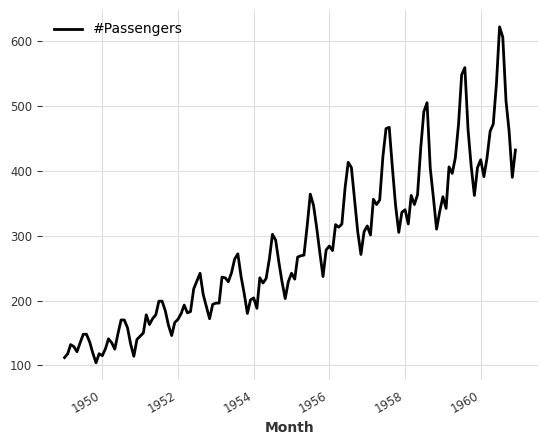

In [2]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()
series.plot()


In [3]:
series.tail()

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1960-08-01 1960-09-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

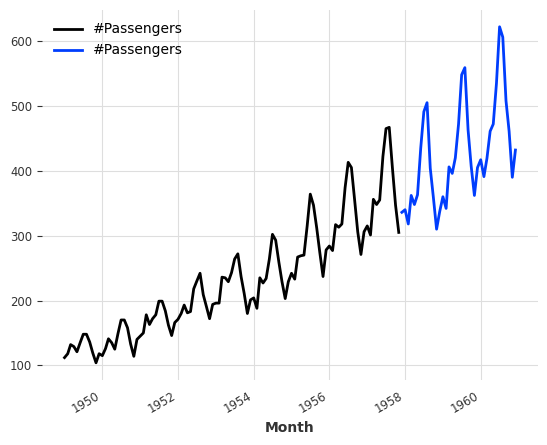

In [4]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

### noise in the series

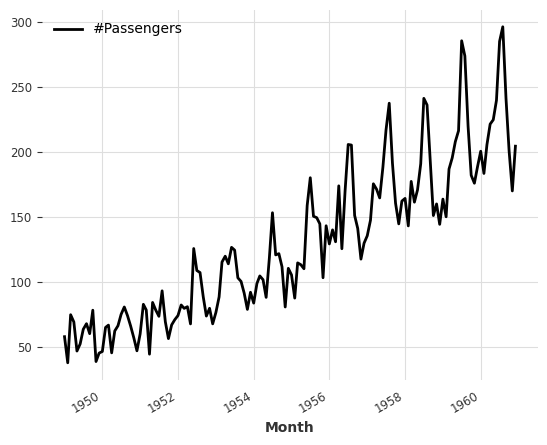

In [5]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 10 * series_noise - 10).plot()

### train and val and fitting

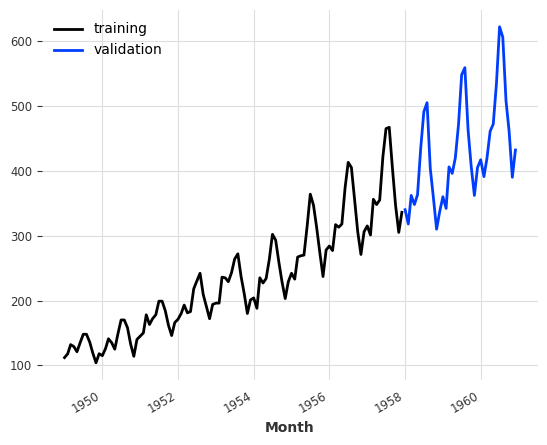

In [6]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


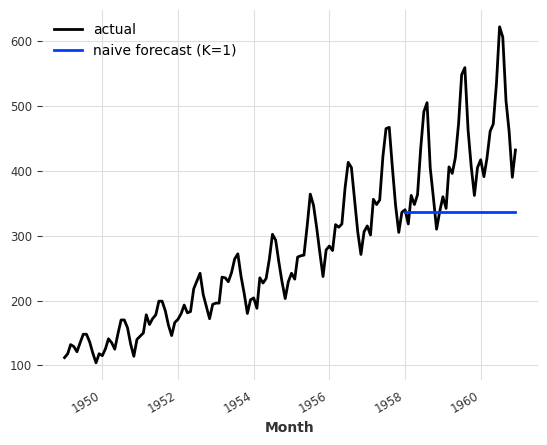

In [7]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

### combined method

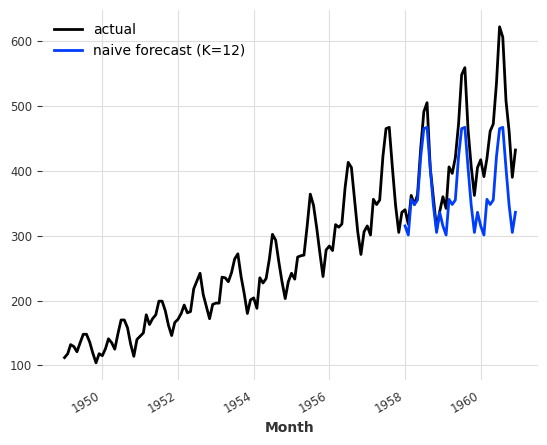

In [8]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

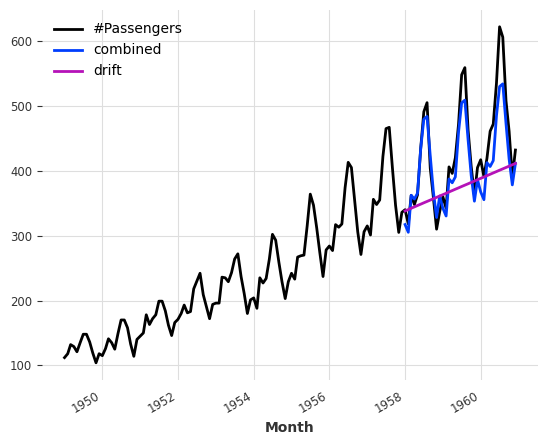

In [9]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [10]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [11]:
from omegaconf import OmegaConf
import hydra


### N-BEATS

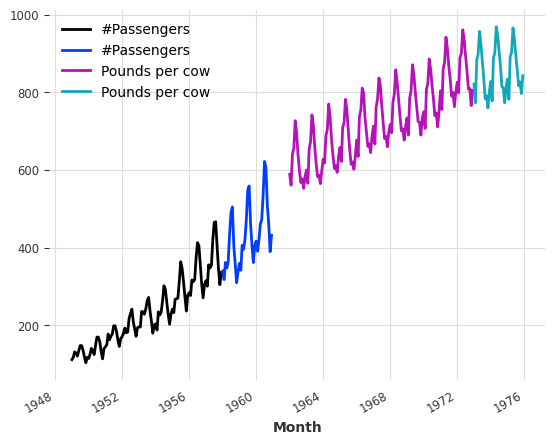

In [2]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

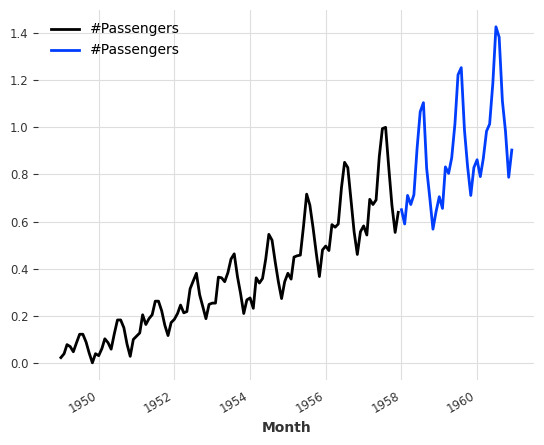

In [7]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])
val_air_scaled = scaler.transform(val_air)
f
train_air_scaled.plot()
val_air_scaled.plot()
train_milk_scaled.plot()

In [14]:
from darts.models import NBEATSModel

# import pytorch lightning wandb logger
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="ts_snr", entity="mahdigilany", name='nbeats')
pl_trainer_additional_kwargs = {'logger': wandb_logger}

model = NBEATSModel(input_chunk_length=24,
                    output_chunk_length=12,
                    random_state=42,
                    batch_size=32,
                    save_checkpoints=False,
                    nr_epochs_val_period=1,
                    model_name=None,
                    pl_trainer_kwargs=pl_trainer_additional_kwargs)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True, num_loader_workers=0, val_series=None) # trainer: pl.Trainer can be passed here # for more control on dataset and series slicing, call fit_from_dataset() instead


"""_summary_

creating new model
1. our model, class new_model(PastCovariatesTorchModel), inherits from "PastCovariatesTorchModel" class
2. new_model() class should have _create_model() which returns our model lightning module class, class new_model_lightning_module(PLPastCovariatesModule)
3. new_model_lightning_module() class only needs to have a forward() method and inherits from "PLPastCovariatesModule"
4. in case of chaning optimizer, we need to add configure_optimizers() method to new_model_lightning_module() class
5. we can fit the model with specifying trainer and dataset in fit_from_dataset() method , otherwise the dataset is created by "PastCovariatesTorchModel" class
6. we can pass our trainer to .fit() and for easier add of new trainer, we can use new_model._setup_trainer()-> pl.Trainer for setting up the trainers and then add to it by appending. 

`fit_from_dataset()` with a custom :class:`darts.utils.data.TrainingDataset`

creating dataset
target is the last element by convention train_batch[-1]
"""


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mahdigilany. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 28.77it/s, v_num=l034, train_loss=0.0026]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 28.60it/s, v_num=l034, train_loss=0.0026]


'_summary_\n\ncreating new model\n1. our model, class new_model(PastCovariatesTorchModel), inherits from "PastCovariatesTorchModel" class\n2. new_model() class should have _create_model() which returns our model lightning module class, class new_model_lightning_module(PLPastCovariatesModule)\n3. new_model_lightning_module() class only needs to have a forward() method and inherits from "PLPastCovariatesModule"\n4. in case of chaning optimizer, we need to add configure_optimizers() method to new_model_lightning_module() class\n5. we can fit the model with specifying trainer and dataset in fit_from_dataset() method , otherwise the dataset is created by "PastCovariatesTorchModel" class\n6. we can pass our trainer to .fit() and for easier add of new trainer, we can use new_model._setup_trainer()-> pl.Trainer for setting up the trainers and then add to it by appending. \n\n`fit_from_dataset()` with a custom :class:`darts.utils.data.TrainingDataset`\n\ncreating dataset\ntarget is the last ele

In [17]:
train_air_scaled

<TimeSeries (DataArray) (Month: 108, component: 1, sample: 1)>
array([[[0.02203858]],

       [[0.03856748]],

       [[0.077135  ]],

       [[0.06887051]],

       [[0.04683197]],

       [[0.08539945]],

       [[0.12121212]],

       [[0.12121212]],

       [[0.08815429]],

       [[0.04132232]],

...

       [[0.69421494]],

       [[0.67217636]],

       [[0.69146   ]],

       [[0.87603307]],

       [[0.9944904 ]],

       [[1.        ]],

       [[0.8264463 ]],

       [[0.66942155]],

       [[0.55371904]],

       [[0.63911843]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1957-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [2]:
seq_ds = model._build_train_dataset([train_air_scaled], past_covariates=None, future_covariates=None, max_samples_per_ts=None)
seq_ds.ds.__dict__


<module 'pytorch_lightning.loggers' from '/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/loggers/__init__.py'>

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]


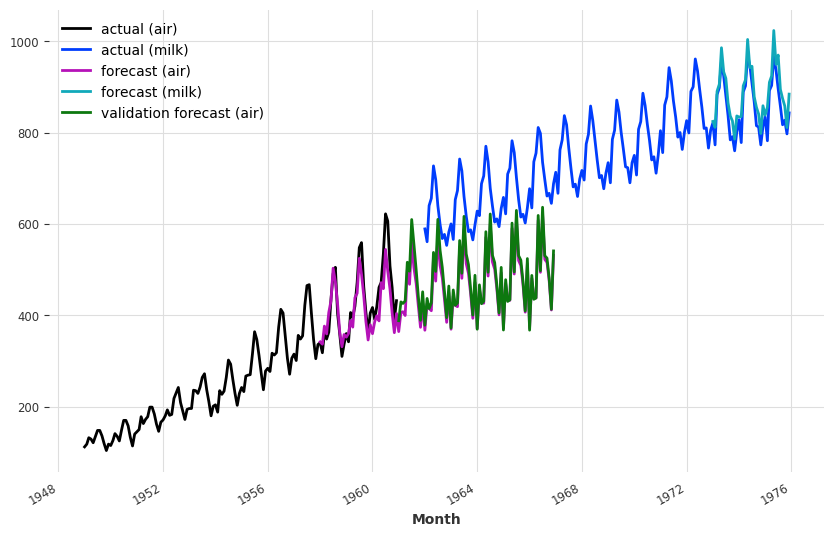

In [16]:
pred_air = model.predict(series=train_air_scaled, n=108)
pred_milk = model.predict(series=train_milk_scaled, n=36)
pred_air_val = model.predict(series=val_air_scaled, n=72)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])
pred_air_val = scaler.inverse_transform(pred_air_val)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")
pred_air_val.plot(label="validation forecast (air)")

In [17]:
val_air

<TimeSeries (DataArray) (Month: 36, component: 1, sample: 1)>
array([[[340.]],

       [[318.]],

       [[362.]],

       [[348.]],

       [[363.]],

       [[435.]],

       [[491.]],

       [[505.]],

       [[404.]],

       [[359.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1958-01-01 1958-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### xarray

In [18]:

import xarray as xr

np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
time = pd.date_range("2014-09-06", periods=3)
reference_time = pd.Timestamp("2014-09-05")

da = xr.DataArray(
     data=temperature,
     dims=["x", "y", "time"],
     coords=dict(
         lon=(["x", "y"], lon),
         lat=(["x", "y"], lat),
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="Ambient temperature.",
         units="degC",
     ),
 )

In [19]:
time

DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-08'], dtype='datetime64[ns]', freq='D')

In [20]:
ar = np.random.randint(5, size=(3, 2))
# pd.Series(range(3), index=list("abc"), name="foo")
# xr.DataArray(pd.Series(range(3), index=list("abc"), name="foo"))

In [21]:
pd_df = pd.DataFrame(ar, columns=["a", "b"])
pd_df

,a,b
0,0,1
1,1,0
2,1,4


In [22]:
xr.DataArray(pd_df)

<xarray.DataArray (dim_0: 3, dim_1: 2)>
array([[0, 1],
       [1, 0],
       [1, 4]])
Coordinates:
  * dim_0    (dim_0) int64 0 1 2
  * dim_1    (dim_1) object 'a' 'b'

In [23]:
train_air_scaled
# train_milk_scaled

<TimeSeries (DataArray) (Month: 108, component: 1, sample: 1)>
array([[[0.02203858]],

       [[0.03856748]],

       [[0.077135  ]],

       [[0.06887051]],

       [[0.04683197]],

       [[0.08539945]],

       [[0.12121212]],

       [[0.12121212]],

       [[0.08815429]],

       [[0.04132232]],

...

       [[0.69421494]],

       [[0.67217636]],

       [[0.69146   ]],

       [[0.87603307]],

       [[0.9944904 ]],

       [[1.        ]],

       [[0.8264463 ]],

       [[0.66942155]],

       [[0.55371904]],

       [[0.63911843]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1957-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [3]:
import xarray as xr
data = xr.DataArray(np.random.randn(2, 3, 3), dims=("time", "x", "y"), coords={"time": [0,1], "x":[5,10,20]}, name="data")

In [4]:
data.to_dataframe()

data
time x  y          
0    5  0 -1.570776
        1 -0.618605
        2  0.333743
     10 0  0.852986
        1  2.140152
        2  1.268001
     20 0  0.609183
        1 -1.503763
        2  0.143654
1    5  0  0.537612
        1  1.019433
        2 -0.219272
     10 0  1.693336
        1 -0.132035
        2 -0.510971
     20 0  1.865165
        1 -0.075428
        2 -0.169775

In [5]:
data["time"==0]

<xarray.DataArray 'data' (x: 3, y: 3)>
array([[-1.57077578, -0.61860499,  0.33374252],
       [ 0.85298628,  2.14015158,  1.26800075],
       [ 0.60918281, -1.50376277,  0.14365435]])
Coordinates:
    time     int64 0
  * x        (x) int64 5 10 20
Dimensions without coordinates: y

In [15]:
data.groupby("time")[0]

<xarray.DataArray 'data' (x: 3, y: 3)>
array([[-1.57077578, -0.61860499,  0.33374252],
       [ 0.85298628,  2.14015158,  1.26800075],
       [ 0.60918281, -1.50376277,  0.14365435]])
Coordinates:
    time     int64 0
  * x        (x) int64 5 10 20
Dimensions without coordinates: y

### Spectrogram and lombScargle

In [3]:
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/  main.py     OLD/       requirements.txt  src/
logs/     notebooks/  README.md  scripts/          wandb/


In [267]:
from src.data.registry.data_registry import create_dataset, create_noisy_dataset
from darts.timeseries import concatenate
train_ts, val_ts, test_ts, scaler = create_dataset('air_passengers')
train_noisy_ts, val_noisy_ts, test_noisy_ts, scaler_noisy = create_noisy_dataset('air_passengers', noise_std=50)
series_ts = concatenate([train_ts, val_ts])._xa.values.reshape(-1)
series_noisy_ts = concatenate([train_noisy_ts, val_noisy_ts])._xa.values.reshape(-1)


(29, 2)


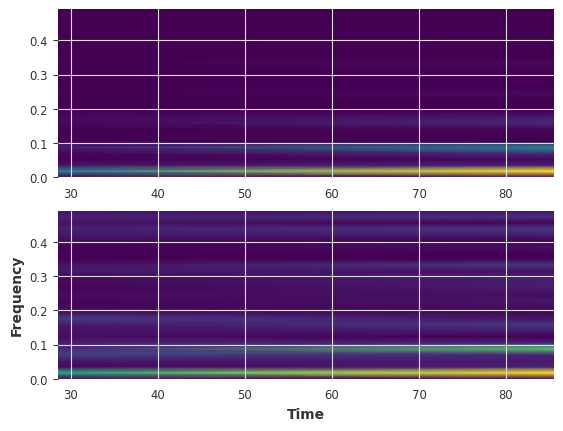

In [268]:
from scipy.signal import periodogram, spectrogram
nperseg = len(series_ts)//2
noverlap = 0
f, t, Sxx = spectrogram(series_ts, nperseg=nperseg, noverlap=noverlap)
f_noisy, t_noisy, Sxx_noisy = spectrogram(series_noisy_ts, nperseg=nperseg, noverlap=noverlap)
print(Sxx.shape)

# n = 3 # to remove noise power
# Sxx_noisy[n:,:] = Sxx[n:,:]

fig, (ax1, ax2) = plt.subplots(2,1,)
ax1.pcolormesh(t, f, Sxx, shading='gouraud')
ax2.pcolormesh(t_noisy, f_noisy, Sxx_noisy, shading='gouraud')
# plt.ylim(0, .1)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

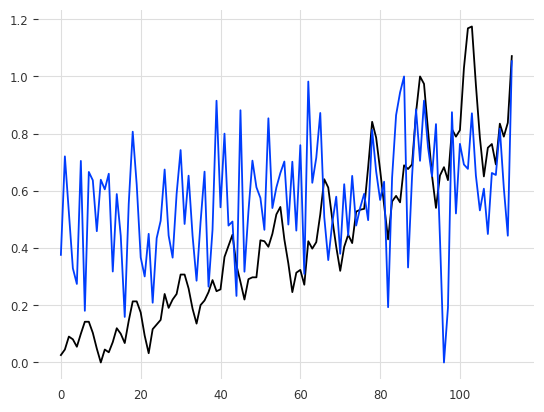

In [186]:
plt.plot(range(len(series_ts)), series_ts)
plt.plot(range(len(series_noisy_ts)), series_noisy_ts)

In [189]:
from scipy.signal import lombscargle
nout = 1000000
w = np.linspace(0.01, 10, nout)
pgram = lombscargle(range(len(series_ts)), series_ts, w, normalize=True)
pgram_noisy = lombscargle(range(len(series_noisy_ts)), series_noisy_ts, w, normalize=True)

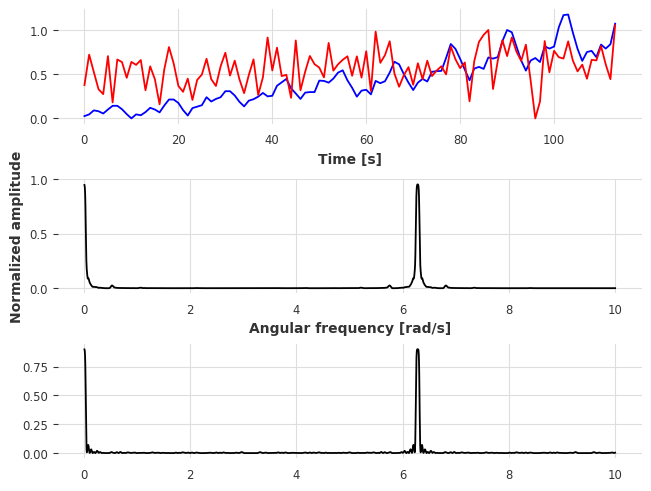

In [191]:
fig, (ax_t, ax_w, ax_w_noisy) = plt.subplots(3, 1, constrained_layout=True)
ax_t.plot(range(len(series_ts)), series_ts, 'b-')
ax_t.set_xlabel('Time [s]')
ax_t.plot(range(len(series_noisy_ts)), series_noisy_ts, 'r-')
ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w_noisy.plot(w, pgram_noisy)
plt.show()

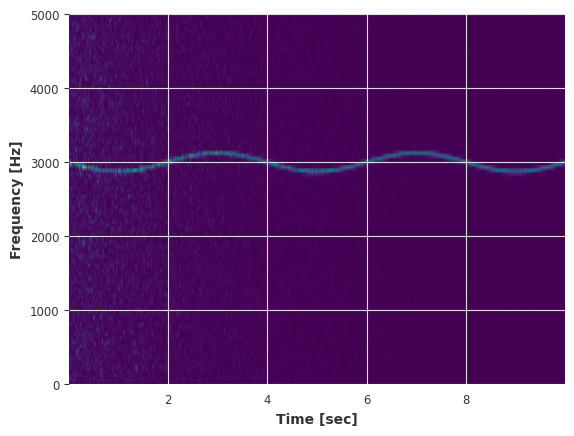

In [45]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
x.shape
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [280]:
from pyts.decomposition import SingularSpectrumAnalysis

X = series_noisy_ts.reshape(1, -1)
# We decompose the time series into three subseries
window_size = 24
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=window_size, groups=None)
X_ssa = ssa.fit_transform(X)


X_ssa.shape

(24, 114)

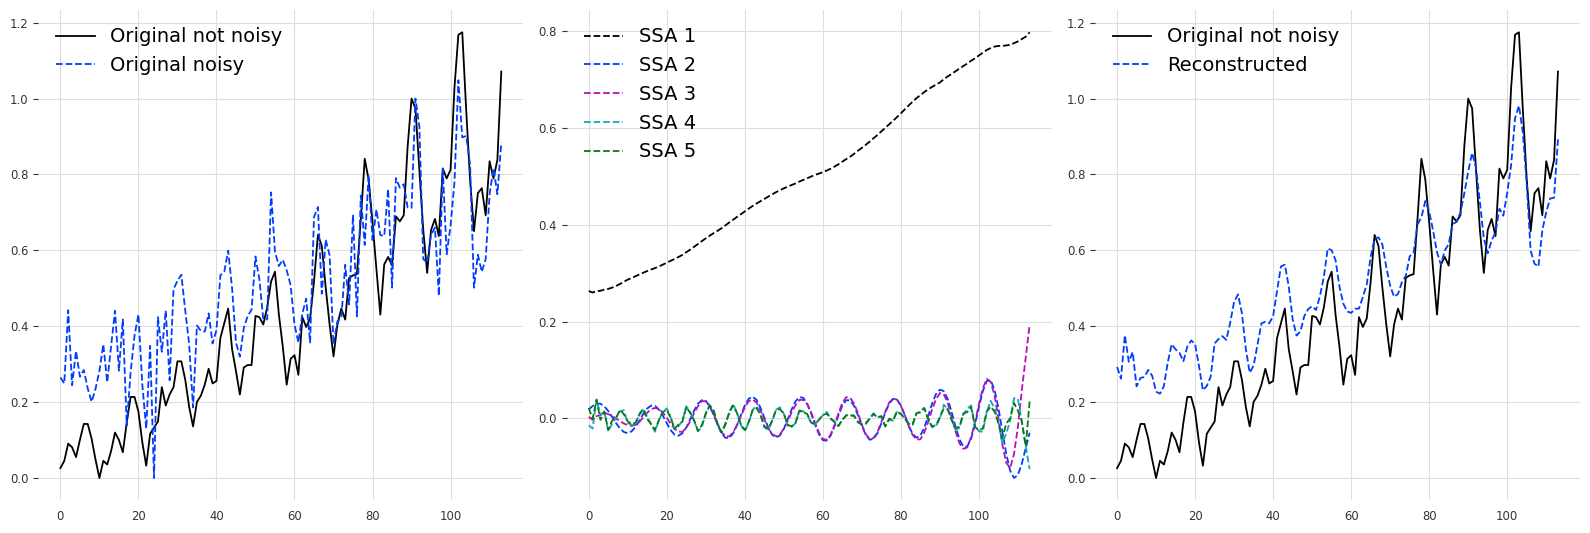

In [285]:
n_reconstructed_features = 5
recon_X = sum([X_ssa[i] for i  in range(n_reconstructed_features)])

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(131)
ax1.plot(series_ts, '-', label='Original not noisy')
ax1.plot(X[0], '--', label='Original noisy')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(132)
for i in range(n_reconstructed_features):
    ax2.plot(X_ssa[i], '--', label=f'SSA {i + 1}')
ax2.legend(loc='best', fontsize=14)

ax3 = plt.subplot(133)
ax3.plot(series_ts, '-', label='Original not noisy')
ax3.plot(recon_X, '--', label='Reconstructed')
ax3.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()